# DBSCAN code tutorial:
In this notebook, we will provide some code example of how to do DBSCAN, Agglomerative, and K-medroids clustering. We will primarily 

## Part 1: DBSCAN Intuition

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

In [12]:
##generate a fake dataset. 
##Note that here I intentionally made the std low so it would be a better fit to use DBSCAN as clusterin method!
X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


In [13]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [14]:
#run DBSCAN function from sklearn package. Note that Epsilon and min=samples here are chosen arbitrarily 
#so we can test it out and adjust accordingly.
dbscan = DBSCAN(eps=0.3, min_samples=2)
clusters = dbscan.fit_predict(X)

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

Note that the above results is not exactly ideal, which is because our parameters are not chosen carefully. Now we adjust the parameters to improve on the result:

In [16]:
new_dbscan = DBSCAN(eps=0.7, min_samples=2)
new_clusters = new_dbscan.fit_predict(X)

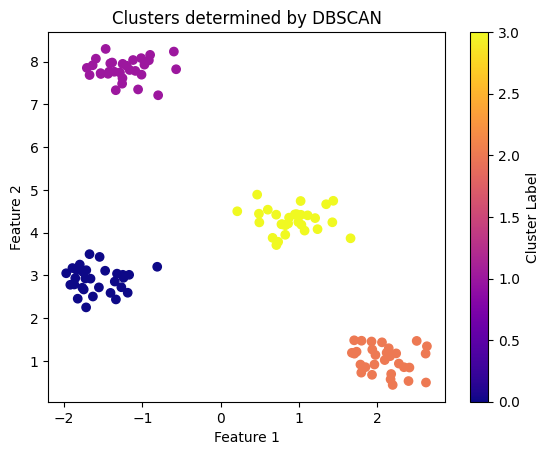

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=new_clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

## Part2: Comparing Time and Quality of DBSCAN vs. other clustering algorithms

We can compare the time complexity of DBSCAN to algorithms we've already been introduced to using the timeit library. First we'll define the previous algorithms (k-means and hierarchical).

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# def hierarchical_cluster(n):
X, y_true = make_blobs(n_samples=300, 
                    centers=4,
                    cluster_std=0.30, 
                    random_state=0)
Z = linkage(X, 
            method='single', 
            metric='euclidean') 

We specify that we want 4 clusters from the data using SciPy's fcluster function:

In [19]:
# Specifying the number of clusters
num_clusters = 4

# Assigning cluster labels based on the hierarchical clustering results
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

Let's compare the quality of fit to the actual labels using silhouette score.

In [20]:
from sklearn.metrics import silhouette_score

def quality(fit, labels):
    # Evaluate clustering performance
    silhouette_avg = silhouette_score(fit, labels)
    print("Silhouette Score:", silhouette_avg)
quality(X, cluster_labels)

Silhouette Score: 0.8409676710250639


The silhouette score is close to 1, meaning the fit is pretty good.

Now we'll reproduce code for clustering using K-means.

In [21]:
from sklearn.cluster import KMeans

# Code snippet taken from Eni's clustering walkthrough
X, y_true = make_blobs(n_samples=200, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

kmeans = KMeans(n_clusters=4)  # step 1: initialize the model
kmeans.fit(X)                  # step 2: fit the data to the model
y_kmeans = kmeans.predict(X)   # step 3: prediction

In [22]:
quality(X, y_kmeans)

Silhouette Score: 0.8408057662056734


Finally, we can wrap the previous algorithms into functions and compare their time complexity. We'll time them different input sizes using the timeit library.

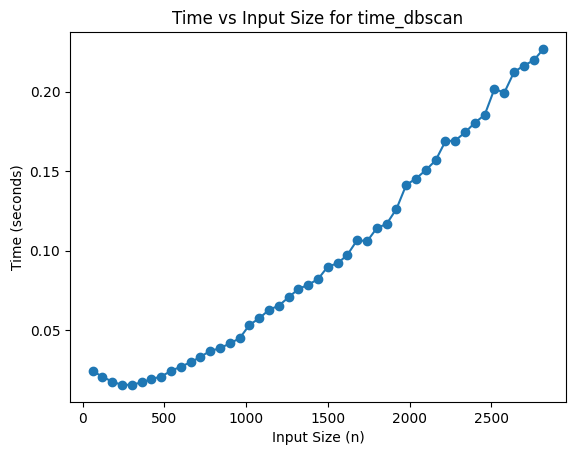

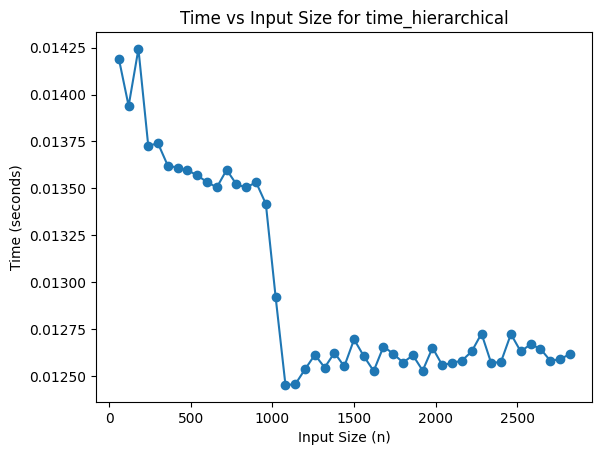

In [23]:
import timeit

def run_dbscan(n):
    X, y_true = make_blobs(n_samples=n, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)
    dbscan = DBSCAN(eps=0.3, min_samples=2)
    clusters = dbscan.fit_predict(X)
    return clusters

def run_k_means(n):
    X, y_true = make_blobs(n_samples=n, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

    kmeans = KMeans(n_clusters=4)  # step 1: initialize the model
    kmeans.fit(X)                  # step 2: fit the data to the model
    y_kmeans = kmeans.predict(X)   # step 3: prediction
    return y_kmeans

def run_hierarchical(n, num_clusters):
    X, y_true = make_blobs(n_samples=300, 
                    centers=4,
                    cluster_std=0.30, 
                    random_state=0)
    Z = linkage(X, 
                method='single', 
                metric='euclidean') 
    
    # Assigning cluster labels based on the hierarchical clustering results,
    # supposing we know num_clusters ahead of time
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
    return cluster_labels

# Define different input sizes
input_sizes = range(60, 2880, 60)

def time_kmeans(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_dbscan({n})', globals=globals(), number=20)
        times.append(time)
    return times

def time_hierarchical(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_hierarchical({n}, 4)', globals=globals(), number=20)
        times.append(time)
    return times

def time_dbscan(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_dbscan({n})', globals=globals(), number=20)
        times.append(time)
    return times

# Plotting
def plot(function):
    plt.plot(input_sizes, function(input_sizes), marker='o')
    plt.title(f'Time vs Input Size for {function.__name__}')
    plt.xlabel('Input Size (n)')
    plt.ylabel('Time (seconds)')
    plt.show()
plot(time_dbscan)
plot(time_hierarchical)
plot(time_kmeans)

Hierarchical clustering is currently fastest, followed by DBSCAN. However, we have hard-coded in that the number of clusters should be 4 for hierarchical, giving it the advantage of not needing to run its course. DBSCAN is slightly faster than K-means, and this is a trend that remains for larger n.

## Part 3: DBSCAN for Word Embedding Clustering

We will reference the cluster algorithm tutorial notebook Eni posted earlier and use the same example

First let's import/download packages we need for this example. 

In [24]:
import numpy as np
import gensim.downloader as api
from sklearn.cluster import DBSCAN
import sklearn.datasets
from nltk.tokenize import word_tokenize
import nltk

Now, let's read in the dataset.

In [25]:
groups = ['alt.atheism', 'comp.graphics', 'rec.autos', 
          'rec.sport.baseball', 'sci.med', 'talk.politics.guns']


train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(train_data.filenames), len(test_data.filenames))
data = train_data.data
print(data[:10])

3395 2261
["From: david@stat.com (David Dodell)\nSubject: HICN610 Medical Newsletter, Part 2/4\nReply-To: david@stat.com (David Dodell)\nDistribution: world\nOrganization: Stat Gateway Service, WB7TPY\nLines: 708\n\n\n------------- cut here -----------------\n\n\n\n\n\n\n\n\n\nHICNet Medical Newsletter                                              Page 13\nVolume  6, Number 10                                           April 20, 1993\n\n                       Gonorrhea -- Colorado, 1985-1992\n                       ================================\n                   SOURCE: MMWR 42(14)   DATE: Apr 16, 1993\n\n     The number of reported cases of gonorrhea in Colorado increased 19.9% \nfrom 1991 to 1992 after declining steadily during the 1980s. In comparison, in \nthe United States, reported cases of gonorrhea in 1992 continued an overall \ndecreasing trend (1). This report summarizes an analysis of the increase in \ngonorrhea in Colorado in 1992 and characterizes trends in the occurren

In [29]:
#pip install spacy

In [30]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_lg") # Generates embeddings using GloVe

# EXAMPLE:
# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)
print(doc)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)


When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously. “I can tell you very senior CEOs of major American car companies would shake my hand and turn away because I wasn’t worth talking to,” said Thrun, in an interview with Recode earlier this week.
Noun phrases: ['Sebastian Thrun', 'self-driving cars', 'Google', 'few people', 'the company', 'him', 'I', 'you', 'very senior CEOs', 'major American car companies', 'my hand', 'I', 'Thrun', 'an interview', 'Recode']
Verbs: ['start', 'work', 'drive', 'take', 'tell', 'shake', 'turn', 'talk', 'say']
Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun GPE
earlier this week DATE


In [31]:
dir(doc)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_bulk_merge',
 '_context',
 '_get_array_attrs',
 '_realloc',
 '_vector',
 '_vector_norm',
 'cats',
 'char_span',
 'copy',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_dict',
 'from_disk',
 'from_docs',
 'from_json',
 'get_extension',
 'get_lca_matrix',
 'has_annotation',
 'has_extension',
 'has_unknown_spaces',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'noun_chunks',
 'noun_chunks_iterator',
 'remove_extension',
 'retokenize',
 'sentiment'

In [32]:
def document_vector(doc):
    words = nlp(doc)
    return words.vector

In [33]:
vectorized = np.array([document_vector(doc) for doc in data])

In [34]:
vectorized.shape

(3395, 300)

In [106]:
##try PCA to reduce the dimensions of the vectors as DBSCAN from sklearn is more applicable 
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
vectorized_reduced = pca.fit_transform(vectorized)

First let's arbitrarily determine the parameters for DBSCAN just to see how the code works.

In [107]:
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='cosine') #use cosine similarity as metric
clusters = dbscan.fit_predict(vectorized_reduced)

In [108]:
clusters

array([-1, -1, -1, ..., -1,  0, -1])

In [109]:
import numpy as np
from collections import Counter

cluster_counts = Counter(clusters)
num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise}")
print(f"Cluster distribution: {dict(cluster_counts)}")

Number of clusters: 13
Number of noise points: 2222
Cluster distribution: {-1: 2222, 0: 974, 1: 3, 2: 77, 3: 5, 4: 85, 5: 4, 6: 4, 7: 3, 11: 5, 8: 3, 9: 3, 10: 4, 12: 3}


However, we can also use Silhouette Score to help us to decide on the parameters. (Credit to Josie and Sophie!)

In the paper we are attempting to replicate, they did 60 rounds with different params to determine what would be the best epsilon and min points. The code below is just a small test/demo we did that does not capture how DBSCAN iteraturation work in academia.

In [105]:
from sklearn.metrics import silhouette_score

for eps in np.arange(0.01, 0.5, 0.01):
    model = DBSCAN(eps=eps, min_samples=3, metric='cosine')
    labels = model.fit_predict(vectorized_reduced)
    if len(set(labels)) > 1: 
        score = silhouette_score(vectorized, labels)
        print(f"eps: {eps:.2f}, clusters: {len(set(labels))}, silhouette score: {score:.3f}")

eps: 0.01, clusters: 4, silhouette score: 0.499
eps: 0.02, clusters: 8, silhouette score: -0.018
eps: 0.03, clusters: 24, silhouette score: -0.213
eps: 0.04, clusters: 33, silhouette score: -0.224
eps: 0.05, clusters: 30, silhouette score: -0.184
eps: 0.06, clusters: 25, silhouette score: -0.168
eps: 0.07, clusters: 21, silhouette score: -0.128
eps: 0.08, clusters: 23, silhouette score: -0.219
eps: 0.09, clusters: 24, silhouette score: -0.275
eps: 0.10, clusters: 20, silhouette score: -0.232
eps: 0.11, clusters: 16, silhouette score: -0.225
eps: 0.12, clusters: 14, silhouette score: -0.220
eps: 0.13, clusters: 13, silhouette score: -0.237
eps: 0.14, clusters: 14, silhouette score: -0.243
eps: 0.15, clusters: 13, silhouette score: -0.218
eps: 0.16, clusters: 15, silhouette score: -0.237
eps: 0.17, clusters: 17, silhouette score: -0.258
eps: 0.18, clusters: 15, silhouette score: -0.267
eps: 0.19, clusters: 13, silhouette score: -0.255
eps: 0.20, clusters: 14, silhouette score: -0.251
eps

The silouette score can helps to determine the eps.

In [103]:
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [104]:
for min_samples in min_samples_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.08, min_samples=min_samples, metric="cosine")
    clusters = dbscan.fit_predict(vectorized)

    # Analyze the clusters
    cluster_counts = Counter(clusters)
    num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
    num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

    # Print the results
    print(f"Results for min_samples={min_samples}:")
    print(f"Number of clusters: {num_clusters}")
    print(f"Number of noise points: {num_noise}")
    print(f"Cluster distribution: {dict(cluster_counts)}\n")


Results for min_samples=2:
Number of clusters: 21
Number of noise points: 286
Cluster distribution: {0: 3061, 1: 3, -1: 286, 2: 2, 3: 3, 4: 2, 5: 5, 6: 2, 7: 4, 8: 3, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2}

Results for min_samples=3:
Number of clusters: 6
Number of noise points: 316
Cluster distribution: {0: 3061, 1: 3, -1: 316, 2: 3, 3: 5, 4: 4, 5: 3}

Results for min_samples=4:
Number of clusters: 3
Number of noise points: 330
Cluster distribution: {0: 3056, -1: 330, 1: 5, 2: 4}

Results for min_samples=5:
Number of clusters: 3
Number of noise points: 343
Cluster distribution: {0: 3026, -1: 343, 1: 9, 2: 17}

Results for min_samples=6:
Number of clusters: 3
Number of noise points: 361
Cluster distribution: {0: 3008, -1: 361, 1: 9, 2: 17}

Results for min_samples=7:
Number of clusters: 3
Number of noise points: 367
Cluster distribution: {0: 3005, -1: 367, 1: 8, 2: 15}

Results for min_samples=8:
Number of clusters: 3
Number of noise points: 

## K medoids code example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn_extra.cluster import KMedoids

In [ ]:
##generate a fake dataset

X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.40, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


In [ ]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [ ]:
#because this is a fake dataset, we already know that there are 4 clusters.

kmedoids = KMedoids(n_clusters=4, random_state=0)
clusters = kmedoids.fit_predict(X)

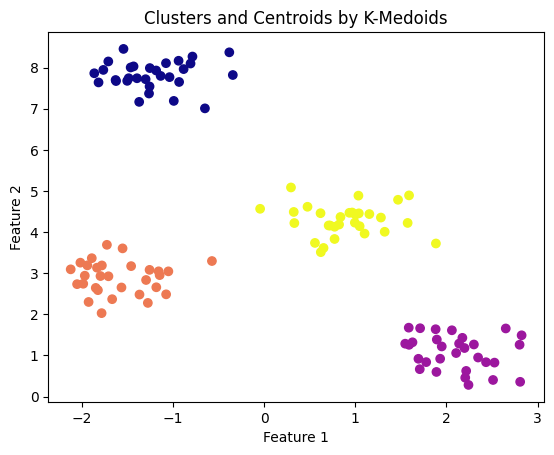

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
#plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], s=250, marker='*', c='red', label='Centroids')
plt.title('Clusters and Centroids by K-Medoids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()